In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
ppallete = "BuGn"
porder = ['MIT9313', 'Natl2A', 'C9B', 'MIT9312', 'MED4']
pedge = 'green'
apallete = "Oranges"
aorder = ['1A3', 'DE', 'DE1', 'ATCC', 'BS11']
aedge='orange'              

In [7]:
data_dpath = r'D:\Users\Osnat\Documents\GitHub\ccpa\fcm_and_fl'

data_dpath = r'C:\Users\wosnat\Documents\GitHub\ccpa\fcm_and_fl'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]


In [69]:
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    #df = df.melt(id_vars=[ 'Sample', 'PRO', 'ALT', 'EXP', 'METHOD','day'],
        #value_vars=['N', 'P', 'TMM', 'N+P+TMM', 'Control ', 'Transfer to Pro99 1:15'],
        #value_name='FL',
        #var_name ='Mode'
    #            )
    return df

In [70]:
temp_dfs = [_load_fcm_fl_csv(data_dpath, fname) for fname in csv_fnames]
df = pd.concat(temp_dfs)
#df.loc[df.FL < 100, 'FL'] = 0

In [71]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,NaN,9312 lowN_FCM1,lowN


In [72]:
df.isna().sum()

0
day          0
VALUE        0
EXP          0
METHOD       0
PRO          0
ALT       1071
Sample       0
MODE         0
dtype: int64

In [73]:
df[df.ALT.isna()]['Sample'].unique()

array(['9312 lowN_FCM1', '9312 lowN_FCM2', '9312 lowN_FCM3',
       '9312 lowN_FL1', '9312 lowN_FL2', '9312 lowN_FL3',
       '9312 lowP_FCM1', '9312 lowP_FCM2', '9312 lowP_FCM3',
       '9312 lowP_FL1', '9312 lowP_FL2', '9312 lowP_FL3',
       '9312_PRO99_FCM1', '9312_PRO99_FCM2', '9312_PRO99_FCM3',
       '9312_PRO99_FL1', '9312_PRO99_FL2', '9312_PRO99_FL3',
       '9313 LD_FCM1', '9313 LD_FCM2', '9313 LD_FCM3', '9313 LD_FL1',
       '9313 LD_FL2', '9313 LD_FL3', '9313 lowN_FCM1', '9313 lowN_FCM2',
       '9313 lowN_FCM3', '9313 lowN_FL1', '9313 lowN_FL2',
       '9313 lowN_FL3', '9313 lowP_FCM1', '9313 lowP_FCM2',
       '9313 lowP_FCM3', '9313 lowP_FL1', '9313 lowP_FL2',
       '9313 lowP_FL3', '9313_PRO99_FCM1', '9313_PRO99_FCM2',
       '9313_PRO99_FCM3', '9313_PRO99_FL1', '9313_PRO99_FL2',
       '9313_PRO99_FL3', 'MED4 lowN_FCM1', 'MED4 lowN_FCM2',
       'MED4 lowN_FL1', 'MED4 lowN_FL2', 'MED4 lowN_FL3'], dtype=object)

In [74]:
df = df.fillna({'ALT': 'N/A'}, )

In [75]:
df.head()

,day,VALUE,EXP,METHOD,PRO,ALT,Sample,MODE
1,6.0,4.005340e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
2,8.0,8.172664e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
3,11.0,1.038500e+08,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
4,13.0,8.916974e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN
5,15.0,5.294342e+07,9312_lowN_1,FCM,MIT9312,N/A,9312 lowN_FCM1,lowN


In [76]:
df.dtypes

0
day       float64
VALUE     float64
EXP        object
METHOD     object
PRO        object
ALT        object
Sample     object
MODE       object
dtype: object

In [77]:
df.isna().sum()

0
day       0
VALUE     0
EXP       0
METHOD    0
PRO       0
ALT       0
Sample    0
MODE      0
dtype: int64

In [78]:
for i in df.columns:
    if i == 'VALUE': 
        continue
    if i == 'day': 
        continue
    print(i, df[i].unique())

EXP ['9312_lowN_1' '9312_lowN_2' '9312_lowN_3' '9312_lowP_1' '9312_lowP_2'
 '9312_lowP_3' '9312_pro99_1' '9312_pro99_2' '9312_pro99_3' '9313_LD_1'
 '9313_LD_2' '9313_LD_3' '9313_lowN_1' '9313_lowN_2' '9313_lowN_3'
 '9313_lowP_1' '9313_lowP_2' '9313_lowP_3' '9313_PRO99_1' '9313_PRO99_2'
 '9313_PRO99_3' 'MED4_lowN_1' 'MED4_lowN_2' 'MED4_lowN_3' 'MED4_1A3_1'
 'MED4_1A3_2' 'MED4_1A3_3']
METHOD ['FCM' 'FL']
PRO ['MIT9312' 'MIT9313' 'MED4']
ALT ['N/A' '1A3']
Sample ['9312 lowN_FCM1' '9312 lowN_FCM2' '9312 lowN_FCM3' '9312 lowN_FL1'
 '9312 lowN_FL2' '9312 lowN_FL3' '9312 lowP_FCM1' '9312 lowP_FCM2'
 '9312 lowP_FCM3' '9312 lowP_FL1' '9312 lowP_FL2' '9312 lowP_FL3'
 '9312_PRO99_FCM1' '9312_PRO99_FCM2' '9312_PRO99_FCM3' '9312_PRO99_FL1'
 '9312_PRO99_FL2' '9312_PRO99_FL3' '9313 LD_FCM1' '9313 LD_FCM2'
 '9313 LD_FCM3' '9313 LD_FL1' '9313 LD_FL2' '9313 LD_FL3' '9313 lowN_FCM1'
 '9313 lowN_FCM2' '9313 lowN_FCM3' '9313 lowN_FL1' '9313 lowN_FL2'
 '9313 lowN_FL3' '9313 lowP_FCM1' '9313 lowP_FCM2' '9313

In [94]:
df['PRO ALT'] = df.PRO + ', ' +df.ALT

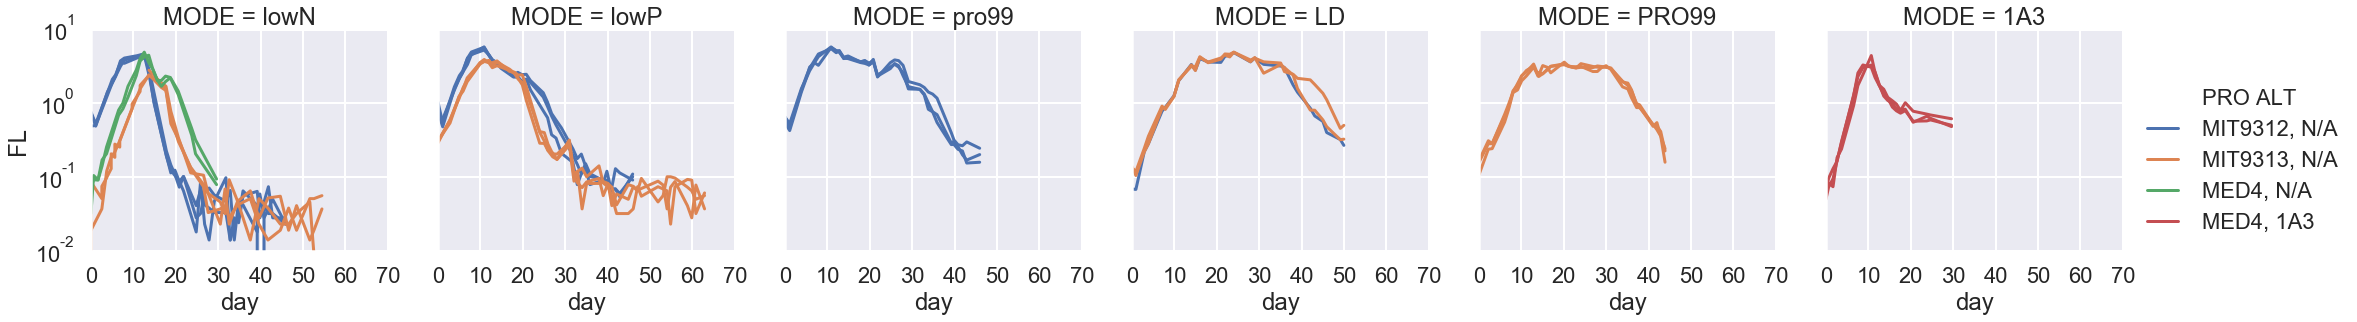

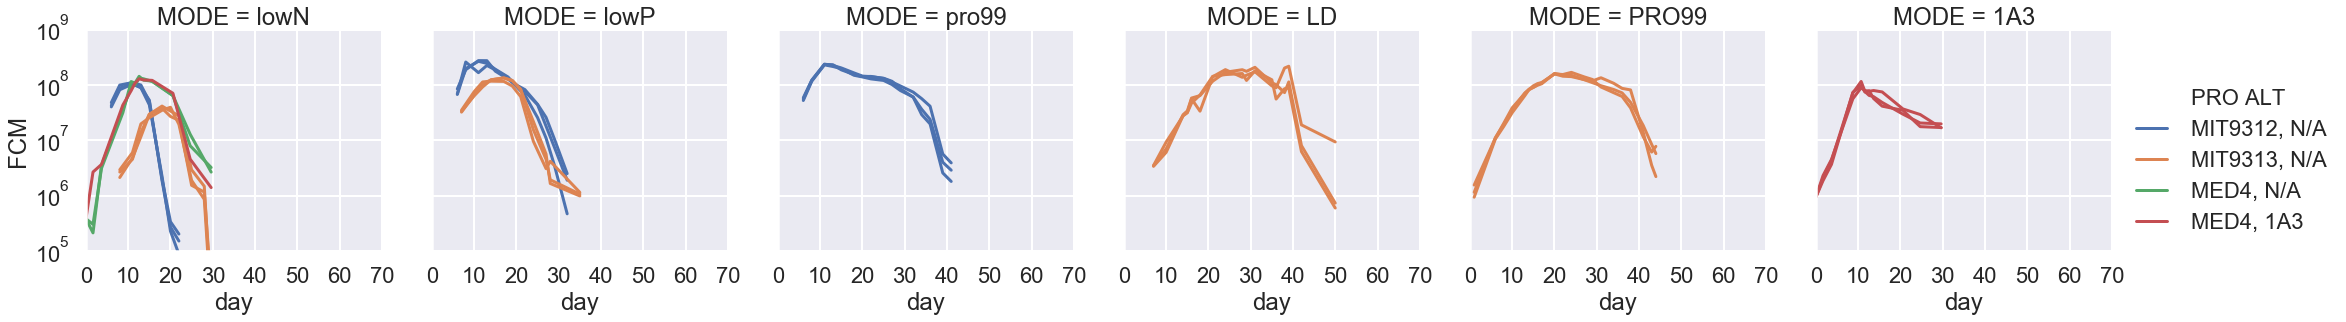

In [95]:
g = sns.relplot(data=df.loc[df.METHOD=='FL'], col='MODE',  hue='PRO ALT',x='day', y='VALUE', 
            kind='line', estimator=None, units='EXP')
g.set(xlim=(0,70), yscale="log", ylabel='FL')
g = sns.relplot(data=df.loc[df.METHOD=='FCM'], col='MODE',  hue='PRO ALT',x='day', y='VALUE', 
            kind='line', estimator=None, units='EXP')
g.set(xlim=(0,70), yscale="log", ylabel='FCM')


In [83]:
df.groupby(['METHOD']).describe()

0         day                                                             \
        count       mean        std  min        25%    50%    75%    max   
METHOD                                                                     
FCM     375.0  19.866817  11.026723  0.0  11.598611  18.00  28.00  50.00   
FL      807.0  23.298033  15.181467  0.0  10.920000  20.97  34.84  62.89   

0       VALUE                                                                \
        count          mean           std    min           25%          50%   
METHOD                                                                        
FCM     375.0  6.992973e+07  6.415715e+07  0.000  8.198314e+06  61312569.52   
FL      807.0  1.439253e+00  1.494861e+00 -0.023  1.050000e-01         0.80   

0                                   
                 75%           max  
METHOD                              
FCM     1.153120e+08  2.754462e+08  
FL      2.606000e+00  5.830000e+00